# notebook to test scat transform

In [1]:
import tensorflow as tf
import os, sys, time, subprocess, h5py, argparse, logging
import numpy as np
from os.path import join as oj
sys.path.append('scat_tf')
from scat_tf import scattering
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 6)

# make scat

In [2]:
# requires NCHW format (cuDNN default - tf is NHWC)
M, N = 32, 32
J = 2 # spatial scale of filter
scat = scattering.Scattering(M=M, N=N, J=J)

# make scat_comp
placeholder = tf.placeholder(tf.float32, (1, 3, 32, 32))
scat_comp = scat(placeholder)
print("M", M, "N", N, "J", J, 'input', placeholder.shape, 'output', scat_comp.shape)

M 32 N 32 J 2 input (1, 3, 32, 32) output (1, 243, 8, 8)


# max activation

In [3]:
def visstd(a, s=0.1): # normalize the image range
    return s * (a - a.mean()) / max(a.std(), 1e-4) + 0.5

def get_filt(scat_comp, placeholder, filt_num, step = 1.5, step_decay = 0.98, num_iters = 75):
    # set up tf vars
    t_score = tf.reduce_mean(scat_comp[0, filt_num, :, :]) # defining the optimization objective
    t_grad = tf.gradients(t_score, placeholder)[0] # behold the power of automatic differentiation!
    im_noise = np.random.uniform(size=(32, 32, 3))
    im_tf = np.expand_dims(np.transpose(im_noise, (2, 0, 1)), 0)

    # maximally activate
    for i in tqdm(range(num_iters)):
        g, score = sess.run([t_grad, t_score], {placeholder: im_tf})
        g /= g.std() + 1e-8 # normalizing the gradient, so the same step size should work for different things        
        im_tf += g * step
        step *= step_decay
            
    im_out = np.transpose(np.array(im_tf)[0], (1, 2, 0))[:, :, 0] # get np array (only red channel)
    return visstd(im_out)

In [ ]:
# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# get filts
num_filts = int(scat_comp.shape[1]) // 3
print(num_filts)
filts = np.empty(shape=(num_filts, 32, 32)) # divide by number of colors
# with tf.device("/cpu:0"):
for filt_num in range(num_filts):
    filts[filt_num] = get_filt(scat_comp, placeholder, filt_num)

81


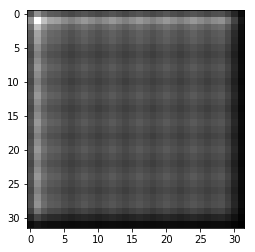

In [6]:
plt.imshow(filts[0], interpolation='None', cmap='gray')
plt.show()